# Интро

Целью данного проекта является построение пайплайна для обучения модели распознания объекта (в данном случае лица, однако данный пайплайн можно использовать и для других объектов). 

**План проекта:**

1. Сбор изображений с помощью веб-камеры


2. Далее перейдем к аннотации. Нужно будет нарисовать на каждом изображении прямоугольник. Для этого мы будем использовать библиотеку LabelMe. 


3. Сбор сотни или тысячи изображений будет недостаточным. Допустим у нас условия нехватки времени и мы не можем тратить целый день на сбор данных. Здесь в дело вступает аугментация данных (расширение). Для решения данной проблемы мы будем использовать другую библиотеку. Данная библиотека расширит наш датасет с помощью инструментов "Обрезание", "Яркость", "Поворот", "Гамма". Данные инструменты будут рандомно изменять изображения. Данные преобразования позволят увеличить датасет в 30 раз.


4. Модель, которой на вход поступят данные состоит из двух моделей (как и большинство моделей, которые решают проблемы поиска предметов на изображении) состоит из модели классификации и регрессии. Модель классификация отвечает за то, чтобы распознать тип объекта (лицо, рука, нога), а модель регрессии, которая будет стараться установить рамку вокруг объекта. Вообще, нам нужно всего две координаты, чтобы создать рамку: верхняя левая и нижняя правая.


5. Далее нам нужно установить функцию потерь. В данном случае подойдет фукнция бинарной классификации (бинарная кроссэнтропия). В данном случае будет два класса: лицо и не лицо. Второй функцией потерь для регресси будет явяться Localization, которая будет оценивать насколько далеко линии рамки расположены от лица. Первый компонент данной функции будет отвечать за то, насколько далеко первая точка (верхняя правая) расположена от объекта, а второй компонент насколько далеко линии ширины и линия длины расположены от объекта. Мы стремимся минимизировать функцию потерь таким образом, чтобы линии рамки настолько близко к объекту, насколько это возможно.


6. В качестве модели мы будем использовать VGG16 модель, которая используется для классификация изображений. Красота этой модели в том, что данная модель уже имеет веса. Она уже была натренирована на огромном количестве данных. После этой модели мы будем использовать наши две модели классификации и регрессии.


7. На выходе из модели мы получим 5 значений. В первом сете значений мы получим 1 значение - это рейндж от 0 до 1 - это будет являеться вероятностью того является ли зафиксированный объект лицом. Во втором сете значений мы получим 4 значения - координаты рамки [x1, y1, x2, y2]. 


8. После мы будем проводить тест в реальном времени.

# Установление окружение и сбор данных

## Сбор данных с помщью Open CV

In [1]:
import os
import time
import uuid #для создания уникальных id при сборе данных
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images') #путь для изображений
number_images = 30 #количество изображений в папке
#мы создадим поочередно несколько сессий с записыванием данных и поместим их в одну папку 
#создать папки нужно ручками

In [3]:
# #для сбора изображений
# cap = cv2.VideoCapture(0) 
# for imgnum in range(number_images): 
#     print('Collecting image {}'.format(imgnum)) #показываем какое изображение собираем
#     ret, frame = cap.read() #считываем данные с камеры. ret - была ли операция успешной, frame - само изображение
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') #добавляем файл в папку и даем ему id с помощью uuid
#     cv2.imwrite(imgname, frame) #сохраняет изображение 
#     cv2.imshow('frame', frame) #показывает что получилось
#     time.sleep(0.5) #0.5 секунд между каждым фото. Это также для того, чтобы мы могли убрать голову, повернуть её, ведь нам
#     #нужно будет взять пару негативных сэмплов (в которых нет лица), чтобы попытаться решить проблему переобучения классификатор

#     if cv2.waitKey(1) & 0xFF == ord('q'): #позволяет закончить луп 
#         break
# cap.release() #отпускает ресурсы камеры
# cv2.destroyAllWindows()

## Аннотация изображений с помощью LabelMe

In [4]:
# !labelme

Далее открывается программа в ней нужно нажать на кнопку Open Dir, выбрать директорию с изображениями, далее нужно нажать на вкладку File, далее Change Outpot Dir и выбрать директорию, куда будут сохраняться лейблы (в данном случае мы уже создали папку Labels). Далее нужно снова нажать на вкладку файл, нажать на Save Automatically (это позволит автоматически изменять и сохранять изображения без нажатия на кнопку Save). Далее идем во вкладку Edit, нажимаем Create Ractangle. Далее аккуратно нужно будет кликнуть на то место, где будет начинаться рамка. Кликаем один раз по данному месту, растягивает рамку, кликаем снова. Появится контейнер, и нам нужно будет вписать в место для текста сверху имя класса (face), далее нажимаем Окей и получаем аннотацию. Чтобы перейти к следующему изображению нужно нажать d. Для изображений, где нет лица просто нужно их скипнуть. Изображения, где лицо закрыто руками тоже нужно скипнуть. 

# Ревью датасета и создание функции для загрузки данных

In [5]:
import tensorflow as tf
import json #для работы с лейблами, т.к. они в формате json
import numpy as np
from matplotlib import pyplot as plt

In [6]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Загрузка изображений в датасет пайплайн

In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False) #добавляем каждый файл в папке ... с форматом .jpg
#шафл на фолс, т.к. функция по умолчанию включает шафл, а мы сделаем шафл позже

In [9]:
#посмотрим работает ли функция (ведет ли она какому-либо файлу, если да, то получим путь к файлу)
images.as_numpy_iterator().next() 

b'data\\images\\002217b8-1b00-11ed-aa69-989a8091f6db.jpg'

In [10]:
#функция для загрузки изображения
#мы написали данную функцию, т.к. мы не можем просто просмотреть images[i] файл 
def load_image(x): 
    byte_img = tf.io.read_file(x) #кодируем изображение в байты
    img = tf.io.decode_jpeg(byte_img) #получаем изображение обратно в виде array 
    return img

In [11]:
images = images.map(load_image) #map - применяет функцию ко всем файлам

In [12]:
images.as_numpy_iterator().next() #посмотрим на результат

array([[[185, 184, 182],
        [183, 182, 180],
        [181, 181, 179],
        ...,
        [ 38,  33,  30],
        [ 40,  32,  29],
        [ 38,  30,  27]],

       [[187, 186, 184],
        [186, 185, 183],
        [184, 184, 182],
        ...,
        [ 39,  34,  30],
        [ 43,  35,  32],
        [ 44,  36,  33]],

       [[187, 187, 185],
        [186, 186, 184],
        [185, 185, 183],
        ...,
        [ 40,  35,  31],
        [ 39,  34,  30],
        [ 42,  37,  31]],

       ...,

       [[250, 250, 248],
        [250, 250, 248],
        [249, 251, 250],
        ...,
        [ 41,  40,  38],
        [ 40,  39,  37],
        [ 43,  42,  40]],

       [[250, 250, 248],
        [250, 250, 248],
        [249, 251, 248],
        ...,
        [ 44,  42,  43],
        [ 42,  40,  41],
        [ 42,  40,  41]],

       [[250, 250, 248],
        [250, 250, 248],
        [249, 251, 248],
        ...,
        [ 47,  45,  48],
        [ 43,  41,  42],
        [ 40,  38,  39]]

In [13]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [14]:
images.as_numpy_iterator().next().shape
#длина, ширина, каналы цвета

(480, 640, 3)

## Посмотрим сырые изображения

In [15]:
image_generator = images.batch(4).as_numpy_iterator() #создаем итератор из батчей из 4 изображений

In [16]:
plot_images = image_generator.next() #сохраняем батч в переменную 

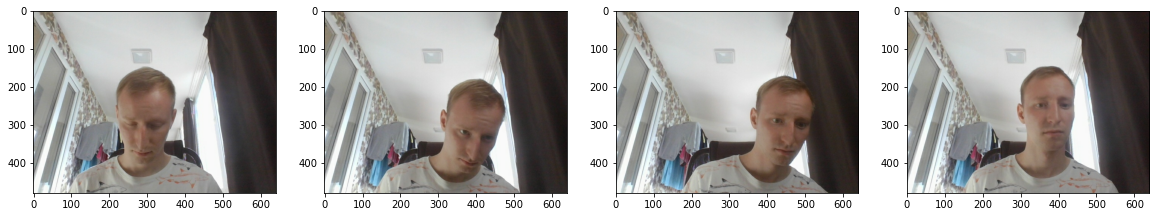

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 
#кол-во колонов, размер фигуры
for idx, image in enumerate(plot_images):
    #idx - индекс в фигуре (ячейка)
    ax[idx].imshow(image) 
plt.show()

# Разделяем данные

Для начала создадим папки с названиями train, test, val внутри папки data.


Внутри попок создадим еще две папки: images, labels

In [18]:
print('70% данных для трейн выборки - это {} изображения'.format(int(90 * 0.7))) #63 изображения для трейна

70% данных для трейн выборки - это 62 изображения


In [19]:
print('20% данных для тестовой и валидационной - это {} изображений'.format(int(90 * 0.15))) #14 для теста, 13 для валидации

20% данных для тестовой и валидационной - это 13 изображений


Идем в папку images и берем оттуда рандомно 63 изображения, вырезаем и вставляем в train/images, тоже самое соответствуенно делаем с тестом и валидацией

Теперь делаем тоже самое для лейблов, но уже с помощью функции

In [20]:
# for folder in ['train','test','val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')): #для каждого файла в каждой из папок
        
#         filename = file.split('.')[0]+'.json' #разбиваем файл через точки и получаем его имя с припиской к формату
#         existing_filepath = os.path.join('data','labels', filename) #засовываем файл с таким именем в папку с лейблом
#         if os.path.exists(existing_filepath): #если такой файл в папке с лейблами уже есть, то 
#             new_filepath = os.path.join('data',folder,'labels',filename) #создаем новый путь
#             os.replace(existing_filepath, new_filepath) #заменяем новый путь на старый (это во избежание ошибок просто)

# Расширим данные на одном примере

## Пайплайн для трансформации

In [21]:
import albumentations as alb #библиотека для расширения данных

In [22]:
# Список аугментация, которые мы добавим в данные
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), #Рандомное обрезание до 450 по высоте и до 450 по ширине
                         #сейчас изображение 480 на 640. Минимальная длина или ширина в идеале должны быть больше самого
                         #большой длины и ширины в параметрах обрезания
                         alb.HorizontalFlip(p=0.5), #Вращает изображение горизонтально по оси y
                         alb.RandomBrightnessContrast(p=0.2), #Рандомно меняет яркость
                         alb.RandomGamma(p=0.2), #Рандомно меняет гамму 
                         alb.RGBShift(p=0.2), #Меняет RGB пространство
                         alb.VerticalFlip(p=0.5)], #Рандом вращает по оси x
                        #Внутри нижнего параметра происходит нормализация изображения.
                        #Это происходит для того, чтобы сообщить аугментатору о том, где находится рамка лейбла
                        #Нормализация нужна для более удобного понимания модель где находится рамка (лучше пропускать
                        #на вход нормализированные, чем абсолютные значения)
                        #К примеру лейбл имеет размер такие точки рамки: x_min = 98, x_max = 420 (точки, между которыми
                        #чертится линия), y_min=345, y_max=462. 
                        #Таким образом мы делим ширину лейбла на ширину всего изображения (x_min / 640, x_max/640) и также
                        #поступаем с длиной (y_min / 480, y_max / 480).
                        #Получаем новые значения и таким образом нормализовали лейбл, чтобы мы могли работать с ним 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## Тестовая трансформация

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','00be9a87-1b00-11ed-ae02-989a8091f6db.jpg')) #путь к рандомному изображению

In [24]:
#Берем соответствующий лейбл
with open(os.path.join('data', 'train', 'labels', '00be9a87-1b00-11ed-ae02-989a8091f6db.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points'] #получаем координаты лейбла (x_min, y_min и т.д.)

[[349.45833333333337, 175.0], [524.9791666666667, 408.8541666666667]]

In [26]:
#собираем координаты изображения
coords = [0,0,0,0] #сначала создаем пустые координаты
#заполняем координаты поочереди
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords #получаем вектор с координатами 

[349.45833333333337, 175.0, 524.9791666666667, 408.8541666666667]

In [28]:
#покажем как работает нормализация координат
coords = list(np.divide(coords, [640,480,640,480])) #каждая координата делится на соответствующую длина параметра рамки

In [29]:
#Таким образом мы преобразовали преобразовали координаты из простой паскальной системы в  нужный для альбументации формат
coords

[0.5460286458333334, 0.3645833333333333, 0.8202799479166668, 0.851779513888889]

Применимим созданый аугментатор

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [31]:
augmented

{'image': array([[[219, 197, 188],
         [255, 248, 240],
         [250, 237, 228],
         ...,
         [ 39,  41,  52],
         [ 38,  39,  51],
         [ 34,  35,  46]],
 
        [[225, 198, 173],
         [255, 236, 213],
         [255, 241, 221],
         ...,
         [ 38,  39,  51],
         [ 38,  39,  51],
         [ 35,  36,  47]],
 
        [[221, 191, 150],
         [242, 211, 172],
         [250, 229, 196],
         ...,
         [ 38,  41,  50],
         [ 39,  42,  51],
         [ 36,  38,  47]],
 
        ...,
 
        [[236, 237, 233],
         [236, 237, 233],
         [236, 237, 233],
         ...,
         [ 22,  22,  36],
         [ 21,  21,  35],
         [ 22,  22,  38]],
 
        [[235, 236, 232],
         [235, 236, 232],
         [236, 237, 233],
         ...,
         [ 24,  27,  39],
         [ 24,  27,  39],
         [ 22,  23,  39]],
 
        [[234, 235, 231],
         [234, 235, 231],
         [234, 235, 231],
         ...,
         [ 22,  27,

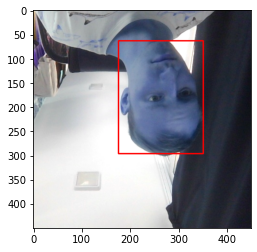

In [32]:
#посмотрим на то как получилось создать рамку лейбла
#cv2.rectangle - рисует прямоугольник, 
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), #это верхние координаты
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), #это нижние координаты
                    (255,0,0), 2) # (B, G, R), толщина рамки

#смотрим на изображение после аугментации
#И нет, изображение не стало синим, просто imshow изменяет с RGB на BGR
plt.imshow(augmented['image'])

# Создание пайплайна для расширения данных

До этого мы создали преобразование для одного изображения. Теперь же нужно создать пайплайн для всех изображений.

In [33]:
# for partition in ['train','test','val']: #для каждого сплита данных
#     for image in os.listdir(os.path.join('data', partition, 'images')): #для каждого изображения в папке
#         img = cv2.imread(os.path.join('data', partition, 'images', image)) #"читаем изображение" и помещаем array в перменную

#         coords = [0,0,0.00001,0.00001]
#         label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path): #чекаем есть ли для изображения аннотация, т.к. мы создавали изображения с негативным
#             #классом (где нет лица)
#             #Если аннотации нет, то мы создадим дефолтную аннотацию coords (выше). Другими словами мы сделаем нулевые координаты
#             #нулевым классом
#             #если аннотация для изображения есть, то мы делаем мы то же преобразование с нормализацией и вычислением 
#             #координат рамки, которую уже делали 
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             coords[0] = label['shapes'][0]['points'][0][0]
#             coords[1] = label['shapes'][0]['points'][0][1]
#             coords[2] = label['shapes'][0]['points'][1][0]
#             coords[3] = label['shapes'][0]['points'][1][1]
#             coords = list(np.divide(coords, [640,480,640,480]))

#         try: 
#             #для каждого изображения мы создадим 60 его аугментированных версий
#             for x in range(60):
#                 #поставляем изображение в аугментатор 
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) 
#                 #"читаем" изображение и добалвяем его в новую папку aug_data/partition(train, test, val)/images, далее
#                 #создаем файл с расширением jpg и помещаем внутри него аугментированное изображение
#                 cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

#                 annotation = {} #словарь для координат аннотаций 
#                 annotation['image'] = image #для каждого изображения из каждого словаря берем изображение

#                 #если лейбл существует 
#                 if os.path.exists(label_path):
#                     #если не нашли рамку, то заполняем нулями
#                     if len(augmented['bboxes']) == 0: 
#                         annotation['bbox'] = [0,0,0,0]
#                         annotation['class'] = 0 
#                     else: 
#                         #иначе берем координаты из словаря
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
#                 else: 
#                     #если лейбл не существует, то заполняем нулями
#                     annotation['bbox'] = [0,0,0,0] #класс 0, если на изображении нет аннотации 
#                     annotation['class'] = 0 

#                 #заполняем папку с лейблами json файлами
#                 with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(e)

## Загрузка датасета в TensorFlow

In [34]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False) #берем изображения из папки
train_images = train_images.map(load_image) #кодируем изображения в array
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) #изменяем размер изображения
#это делает как для того, чтобы уменьшить вес данных, так и для того, чтобы выборка была более генерализированна
train_images = train_images.map(lambda x: x/255) #нормализуем изображения как для того, чтобы не увеличивались весы, так
# и для того, чтобы сигмойдная функция активации работала должным образом

In [35]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [36]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [37]:
train_images.as_numpy_iterator().next()

array([[[0.9676471 , 0.98039216, 0.97536767],
        [0.96813726, 0.9882353 , 0.9735294 ],
        [0.7925858 , 0.83523285, 0.8425858 ],
        ...,
        [0.49773285, 0.49773285, 0.4898897 ],
        [0.5192402 , 0.51550245, 0.5076593 ],
        [0.5276348 , 0.51911765, 0.5060662 ]],

       [[0.9766544 , 0.9841299 , 0.97745097],
        [0.9759191 , 0.98474264, 0.9739583 ],
        [0.828799  , 0.8670343 , 0.8747549 ],
        ...,
        [0.4961397 , 0.50398284, 0.49221814],
        [0.5093137 , 0.5093137 , 0.5074755 ],
        [0.52824754, 0.5245098 , 0.5117647 ]],

       [[0.97794116, 0.98284316, 0.97745097],
        [0.97990197, 0.98088235, 0.9735294 ],
        [0.9784926 , 0.99552697, 0.99699754],
        ...,
        [0.48278186, 0.490625  , 0.48670343],
        [0.5018382 , 0.5018382 , 0.4939951 ],
        [0.5246936 , 0.5246936 , 0.5168505 ]],

       ...,

       [[0.73382354, 0.74607843, 0.73284316],
        [0.70729166, 0.7268995 , 0.71121323],
        [0.7038603 , 0

# Подготовка лейблов

Кроме признаков нам также нужно загрузить и лейблы

In [38]:
def load_labels(label_path):
    #загружаем файл
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    #возвращаем класс и координаты рамки
    return [label['class']], label['bbox']

## Загрузка данных в датасета TensorFlow

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False) #берем данные из папки
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16])) #применяемм функцию
#

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.7563 , 0.11145, 1.     , 0.6313 ], dtype=float16))

# Соединение изображений и лейблов

In [43]:
#чекнем длину всех папок
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3660, 3660, 840, 840, 720, 720)

In [44]:
#Создадим финальный датасет

In [45]:
train = tf.data.Dataset.zip((train_images, train_labels)) #помещаем сэпмплы в zip с итерацией 
train = train.shuffle(5000) #шафлим данные (лучше, чтобы буфер для шафла был больше длины датасета)
train = train.batch(8) #делаем батчи в размере 8
train = train.prefetch(4) 

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)


In [47]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [48]:
train.as_numpy_iterator().next()[0].shape
#получили 8 батчей, в каждом изображение 120 на 120 на 3 канала

(8, 120, 120, 3)

In [49]:
train.as_numpy_iterator().next()[0] #пиксели изображения

array([[[[0.7058824 , 0.6696078 , 0.6460784 ],
         [0.69718134, 0.6452206 , 0.61875   ],
         [0.68419117, 0.62585783, 0.5915441 ],
         ...,
         [0.96862745, 0.9843137 , 0.98039216],
         [0.9730392 , 0.98088235, 0.970098  ],
         [0.975     , 0.98284316, 0.9759804 ]],

        [[0.67518383, 0.5526348 , 0.53204656],
         [0.64093137, 0.52340686, 0.48363972],
         [0.6283701 , 0.519424  , 0.4719363 ],
         ...,
         [0.9647059 , 0.98039216, 0.9764706 ],
         [0.9794118 , 0.98039216, 0.97990197],
         [0.97794116, 0.98284316, 0.98039216]],

        [[0.68964463, 0.60833335, 0.5685662 ],
         [0.6682598 , 0.6005515 , 0.5612745 ],
         [0.6357843 , 0.59221816, 0.55202204],
         ...,
         [0.97561276, 0.9843137 , 0.98039216],
         [0.9769608 , 0.9769608 , 0.9769608 ],
         [0.97794116, 0.98284316, 0.98039216]],

        ...,

        [[0.83327204, 0.83229166, 0.8151348 ],
         [0.82604164, 0.8270221 , 0.81868875]

In [50]:
train.as_numpy_iterator().next()[1] #лейблы

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1228 , 0.2502 , 0.4746 , 0.7153 ],
        [0.09595, 0.2249 , 0.4663 , 0.7344 ],
        [0.4534 , 0.2351 , 0.84   , 0.8013 ],
        [0.45   , 0.     , 1.     , 0.763  ],
        [0.544  , 0.2676 , 0.874  , 0.682  ],
        [0.508  , 0.08246, 0.978  , 0.7397 ],
        [0.2064 , 0.2184 , 0.557  , 0.686  ],
        [0.4512 , 0.3154 , 0.768  , 0.767  ]], dtype=float16))

Посмотрим на изображения

In [51]:
data_samples = train.as_numpy_iterator() #сохраним итератор

In [52]:
res = data_samples.next() #результат итерации

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


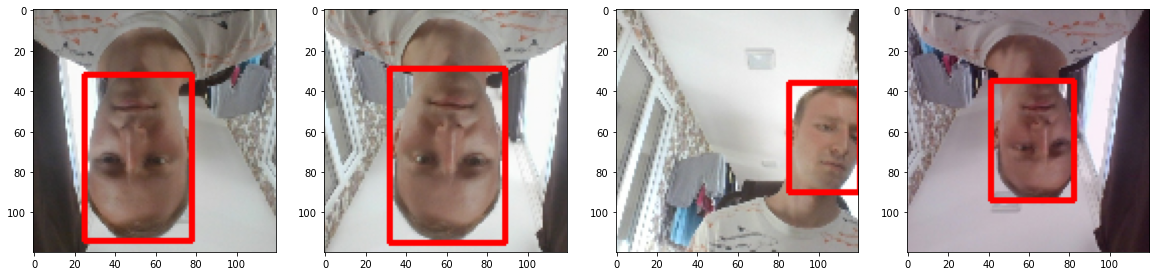

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx] #array с изображением
    sample_coords = res[1][1][idx] #координаты лейбла
    
    #передаем координаты для лейбла
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Создание модели 

Как уже было сказано конечная модель будет состоять из двух моделей, для осуществления такой задумки будем использовать API

In [54]:
#импортируем библиотеки
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [55]:
#инициализируем VGG16
vgg = VGG16(include_top=False) 
#include_top=False - это... Модель vgg является моделью классификации, т. к. мы создаем свою собственную модель, которая
#содержит классификацию и регрессию, то нам не нужны последние слои модели, которые отвечают за аутпут, поэтому мы убираем
#их, то есть include_top=False.

In [56]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [57]:
#функция для начала построения модели 
def build_model(): 
    input_layer = Input(shape=(120,120,3)) #сообщаем модели о форме инпута
    
    #здесь и далее мы создаем слой и в конце каждого слоя в скобочках сообщаем, что должно поступать на инпут в данный слой
    vgg = VGG16(include_top=False)(input_layer) 

    # Модель классификации 
    #Слои внутренние
    #Вместо того, чтобы получать аутпут из каждого слоя в vgg мы будем брать только фаинальные аутпуты 
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    # Показывает класс объекта
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Модель для рамки
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    #4 юнита на каждую из координат
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

Почему facetracker имеет именно такие аутпуты. Давайте посмотрим на данные:

In [58]:
train.as_numpy_iterator().next()[1][0] #здесь содержаться классы

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [59]:
train.as_numpy_iterator().next()[1][1] #а здесь содержатся данные для регрессии. 

array([[0.279   , 0.2742  , 0.652   , 0.8203  ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.465   , 0.3018  , 0.8574  , 0.73    ],
       [0.      , 0.2312  , 0.4343  , 0.8887  ],
       [0.004536, 0.2542  , 0.449   , 0.888   ],
       [0.      , 0.2852  , 0.3916  , 0.7935  ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.4478  , 0.28    , 0.773   , 0.7095  ]], dtype=float16)

Таким образом у нас есть аутпут который нам нужно предсказать в виде классов и регрессии

Протестриуем модель

In [60]:
facetracker = build_model()

In [61]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [62]:
X, y = train.as_numpy_iterator().next() #Х - изображения, y - лейблы

In [63]:
X.shape

(8, 120, 120, 3)

In [64]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 8s 8s/step


In [65]:
classes #вероятность быть классом 

array([[0.5013675 ],
       [0.53718525],
       [0.52552956],
       [0.4518718 ],
       [0.4529213 ],
       [0.45047733],
       [0.47157076],
       [0.41277117]], dtype=float32)

In [66]:
coords[1,:2] #координаты

array([0.4214058 , 0.48123392], dtype=float32)

In [67]:
tf.square(coords[1,:2] - coords[0,:2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00522871, 0.00662007], dtype=float32)>

In [68]:
coords

array([[0.34909594, 0.39987013, 0.4748496 , 0.669805  ],
       [0.4214058 , 0.48123392, 0.534477  , 0.6785527 ],
       [0.3880721 , 0.4124407 , 0.46647528, 0.68237174],
       [0.39141363, 0.37547794, 0.44233114, 0.6289698 ],
       [0.43837723, 0.39339527, 0.5425448 , 0.69852245],
       [0.37636676, 0.2952958 , 0.4669519 , 0.7041476 ],
       [0.38937545, 0.44512478, 0.47600847, 0.6388955 ],
       [0.306832  , 0.37565663, 0.48373282, 0.6981534 ]], dtype=float32)

# Инициализация функции потерь и оптимизация

Установка learning_rate. В данном случае установим lr так, чтобы следующай эпоха брала только 75% от lr предыдущей эпохи

In [69]:
batches_per_epoch = len(train) #в каждом батче 8 сэмплов. В эпохе будет 458 * 8 сэмплов
lr_decay = (1./0.75 -1)/batches_per_epoch #lr в соответствии с нашим требованием 

In [70]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

Теперь инициализируем функцию потерь

In [71]:
def localization_loss(y_true, yhat):            
    #берем дистанцию между настоящей координатой и предсказанной координатой
    #Так делаем с двумя первыми координатами: находи между ними разницу, возводим в квадрат (по цели как RMSE), и суммируем
    #  результаты всех координат
    #Пример: y_true = [0.5545678 , 0.31278563, 0.3644863 , 0.2890176 ], y_hat = [0.5055525 , 0.35319063, 0.32628703, 0.25535405]
    #y_true[:,:2] = [0.5545678 , 0.31278563], y_hat[:, :2] = [0.5055525 , 0.35319063]
    #tf.square(y_true[:,:2] - y_hat[:, :2]) = [0.0024025 , 0.00163256]
    #tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:, :2])) = 0.0040350687
    
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    #находим реальные значения ширины и высоты
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    #находим предсказанные значения высоты и ширины
    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    #та же схема с высотой и шириной
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred)) 
    
    #мы будем стараться уменьшить
    return delta_coord + delta_size 

In [72]:
classloss = tf.keras.losses.BinaryCrossentropy() #функция потерь для классификации
regressloss = localization_loss #для регрессии

In [73]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.73271555>

In [74]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.324966>

# Тренировка нейронной сети

Для начала нужно создать пайплайн для обучения

In [75]:
#создадим класс для обучения
class FaceTracker(Model): 
    #создадим функции, которые требуют модели tensorflow
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs) 
        self.model = facetracker #модель vgg16 с доп слоями, которую инициализровали раньше (она уже обучения на детекцию
        #изображений тела )

    def compile(self, opt, classloss, localizationloss, **kwargs):
        #инициализируем уже созданные нами функции потерь и оптимизации как атрибуты класса
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        #распаковываем батч данных 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            #self.model не забываем, что это уже инициализировали 
            #данная модель возвращает аутпуты по классам и координатам 
            classes, coords = self.model(X, training=True)
            
            #данные аутпуты идут на вход в соответствующие функции потерь
            batch_classloss = self.closs(y[0], classes)
            #Применяем cast чтобы расширить значения в y[1]. Раньше они были 16, но поскольку функция потерь
            #работает с очень маленьким lr, который еще уменьшается мы разворачиваем округленную информацию до 32, чтобы
            #повысить точность вычислений
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            #создаем одну функцию потерь
            #0.5 можно изменять по своему усмотрению, здесь мы просто берем только 50%, т.к. считаем, что localizationloss
            #не является настолько важной как batchloss. Мы отдаем предпочтение классификации в данном случае 
            #вообще при тренировки модели лучше поместить 0.5 в переменную, добавить значения и посмотреть
            #в цикле как меняется результат в зависимости от значений, но мы уже провели тренировки модели и знаем, что
            #0.5 дает хороший результат. 
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            #Вычисляем градиент (куда идет функция потерь)
            #Мы вычисляем градиент по отношению к функции потерь
            #далее мы пускаем градиент на вход в  self.model.trainable_variables
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        #производим градиентный спуск (применяем градинет, чтобы снизить функцию потерь)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    #смотрим на значения на тесте
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    #Для предсказания значений
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [76]:
model = FaceTracker(facetracker) #инициализируем модель 

In [77]:
model.compile(opt, classloss, regressloss)

## Тренировка модели 

In [78]:
logdir='logs'

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [80]:
# hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

In [97]:
# #начертим графики обучения модели
# fig, ax = plt.subplots(ncols=3, figsize=(20,5))

# ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
# ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
# ax[0].title.set_text('Loss')
# ax[0].legend()

# ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
# ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
# ax[1].title.set_text('Classification Loss')
# ax[1].legend()

# ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
# ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
# ax[2].title.set_text('Regression Loss')
# ax[2].legend()

# plt.show()

In [99]:
%load_ext tensorboard

In [100]:
%tensorboard --logdir logs

# Делаем предсказание

## Предсказание на тестовых данных

In [93]:
test_data = test.as_numpy_iterator() #создаем итератор

In [94]:
test_sample = test_data.next() #берем батч

In [95]:
yhat = facetracker.predict(test_sample[0]) #делаем предикт признака

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


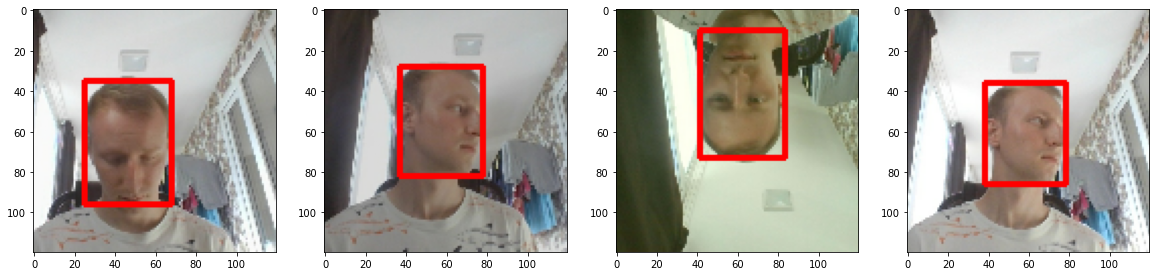

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9: #начертит рамку лейбла, только если вероятность классификации объекта как лица выше 50%
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Сохраним модель

In [86]:
from tensorflow.keras.models import load_model

In [87]:
# facetracker.save('deep_face_detection.h5')

In [88]:
facetracker = load_model('deep_face_detection.h5')

# Предсказание в реальном времени

In [90]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read() #считываем видео 
    frame = frame[50:500, 50:500,:] #изменяем длину и ширину
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #изменяет цвет с BGR на RGB
    resized = tf.image.resize(rgb, (120,120)) #подгоняем изображение под параметры для модели
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0)) #делаем предсказание
    sample_coords = yhat[1][0] #берем только координаты
    
    if yhat[0] > 0.7: #если вероятность объекта быть лицом выше 70%, то
        # Рендер главной рамки 
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Рендер рамки с лейблом
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Рендер текста
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 14ms/step
